<h1 align='center'> Regression in higher dimension & Sparsity</h1> 



<h1 align="center"> Essaddek Othmane </h1> 

Suppose we observe a linear model given by $Y=X\beta+\eta$, knowing $\eta$ is a standard gaussian vector which length is $n=1000$, $\beta$ a vector of size $p=5000$ such as $$\beta_1=\dots=\beta_{15}=1$$
and the rest of the coordinates are zero (Sparse parameter=15). Let's suppose  that columns $X_{.,j}$ of $X$ are $i.i.d$ standard gaussian (not correlated). 
We split our sample : two thirds of the data (approx 660) for the model estimation and what remains (approx 340) for the test process.
The Main objectif is to compare between the different regression model using for instance the function $\textbf{ElasticNet()}$.

Thus we present below all the model that we're going to use for this case study.

$\bullet\, \textbf{Lasso}$: $$\hat{\beta}^L= argmin_{\beta}L_{\lambda}(\beta) \:where\:,  L_{\lambda}(\beta)=\frac{1}{2n}\sum_{i=1}^n(Y_i-X_{i,}\beta)^2+\lambda\vert\vert\beta\vert\vert_1$$
for $\lambda>0$

$\bullet\, \textbf{Ridge}$: $$\hat{\beta}^R= argmin_{\beta}R_{\mu}(\beta) \:where\:  R_{\mu}(\beta)=\frac{1}{2n}\sum_{i=1}^n(Y_i-X_{i,}\beta)^2+\frac{\mu}{2}\vert\vert\beta\vert\vert_2^2$$
for $\mu>0$

$\bullet\, \textbf{ElasticNet}$: $$\hat{\beta}^{EN}= argmin_{\beta}F_{\lambda}(\beta) \:where\:  R_{\mu}(\beta)=\frac{1}{2n}\sum_{i=1}^n(Y_i-X_{i,}\beta)^2+\lambda(\alpha\vert\vert\beta\vert\vert_1+\frac{1-\alpha}{2}\vert\vert\beta\vert\vert_2^2)$$
for $\lambda>0$ and $\alpha\in [0,1]$.
for $\alpha=0$ we obtain the ridge estimator and for $\alpha=1$ we obtain the Lasso estimator   

## Pre-process librairies

In [299]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso, Ridge, lasso_path,LinearRegression
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import urllib
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error






from sklearn.linear_model import LinearRegression,Ridge,Lasso

from sklearn.metrics import r2_score


### a) Estimate the regression vector using  ElasticNet for every valor of the parameter $\alpha$ in $\{0,0.1,0.2,\dots,0.9,1\}$ 

In [314]:
s = 15
p = 5000
n = 1000
#beta initialisation first case
beta = np.array([1 for i in range(s)] + [0 for i in range(p-s)])
eta = np.random.randn(n)
X = np.random.randn(n,p)
y = np.matmul(X, beta) + eta
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2/3)
alpha=np.linspace(0,1,25)
vect_regr={}
for i in range(len(alpha)):
    lbda=np.random.uniform()
    regr=ElasticNet(l1_ratio=lbda,alpha=alpha[i],random_state=0)
    regr.fit(X_train,y_train)
    vect_regr[i]=regr.coef_
# #Regression Vector using ElasticNet()
vect_regr[1]

array([0.83940586, 0.80871525, 0.81426445, ..., 0.01074836, 0.        ,
       0.        ])

### b) Lasso's Regularization Path   

In [49]:
alpha_val , coeff_lasso, _ = lasso_path(X_train, y_train, eps = 2e-2, positive=False, alphas= np.linspace(0,1,25))

array([0.4354836 , 0.18145646, 0.26053681, 0.68662528, 0.5992274 ,
       0.54725408, 0.80448414, 0.53975287, 0.32642112, 0.73251818,
       0.5593401 , 0.25575112, 0.12352084, 0.82647342, 0.15773364,
       0.30606476, 0.62322044, 0.22696278, 0.9762539 , 0.45617277,
       0.30278895, 0.76312525, 0.82962152, 0.71387566, 0.18932805])

### Estimation of the regression vector obtained with Lasso regression 

In [45]:
alpha_val

array([1.        , 0.95833333, 0.91666667, 0.875     , 0.83333333,
       0.79166667, 0.75      , 0.70833333, 0.66666667, 0.625     ,
       0.58333333, 0.54166667, 0.5       , 0.45833333, 0.41666667,
       0.375     , 0.33333333, 0.29166667, 0.25      , 0.20833333,
       0.16666667, 0.125     , 0.08333333, 0.04166667, 0.        ])

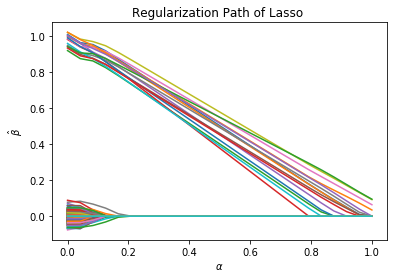

In [12]:
for coeff in coeff_lasso :
    plt.plot(alpha_val, coeff)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\hat{\beta}$')
plt.title('Regularization Path of Lasso ')
plt.show()

## c) Hyperparameter Tuning for Lasso, Ridge and ElasticNet then decide which one is the best  using RandomizedSearch()

In [168]:
#estimators
#Creation of a dictionnary stocking all of our regression's models
parameters_elastic = {
                       "l1_ratio" : np.linspace(0,.5,50), #LASSO if 0, RIDGE if 1
                       "alpha" : np.linspace(0,1, 25)
                     }


parametres_lasso =  {"alpha" : np.linspace(0,1, 25)}
    
parametre_ridre =  {"alpha" : np.linspace(0,1, 25)} 
    

def Regest(E,param,score,cv,n_iter,X,Y,fit=True,best=False,plot_estim=False,MISE=False,pred=False):
    
   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 2/3)
    random_grid = RandomizedSearchCV(
            estimator = E, 
            param_distributions = param, 
            scoring = score,
            cv = cv, 
            verbose = 0, 
            n_jobs = -1, 
            n_iter = n_iter)
    
    random_grid.fit(X_train,Y_train)
    
    best_estim= random_grid.best_estimator_
    best_param= random_grid.best_params_ ,
    score=random_grid.best_score_ ,
    
    if(best==True):
        print(f' best parameter : {best_param}')
        print(f' MSE on train set= {-np.round(score, 2)} ')
        print("\n")
        
        
    if(plot_estim==True):
        
        X_test = StandardScaler().fit_transform(X_test)
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (17,12))
       
            
        predict = best_estim.predict(X_test)
        mse_pred = np.round(mean_squared_error(Y_test, predict), 2)
        x_coord, y_coord = len(Y_test) - 30 , np.max(np.concatenate([Y_test, predict])) - 7
        ax.plot(predict, c = "red",label=r'$\hat{y}$')
        ax.plot(Y_test, c = "black", label = "y", alpha = 0.4)
        ax.legend(frameon=False, loc='lower center', ncol=2)
        ax.set_title(f'estimation')
        plt.show();
            

    if(MISE==True):
        predict = best_estim.predict(X_test)
        mse_pred = np.round(mean_squared_error(Y_test, predict), 2)
        print('MSE on Y_test :',np.round(mse_pred,2))
    
    if(pred==True):
        return(best_estim.predict(X_test))

In [17]:
s = 15
p = 5000
n = 1000
beta = np.array([1 for i in range(s)] + [0 for i in range(p-s)])
eta = np.random.randn(n)
X1 = np.random.randn(n,p)
Y1 = np.matmul(X1, beta) + eta

### $\bullet $ Elastic net

 best parameter : ({'l1_ratio': 0.4897959183673469, 'alpha': 0.18569795158662517},)
 MSE on train set= [2.03] 




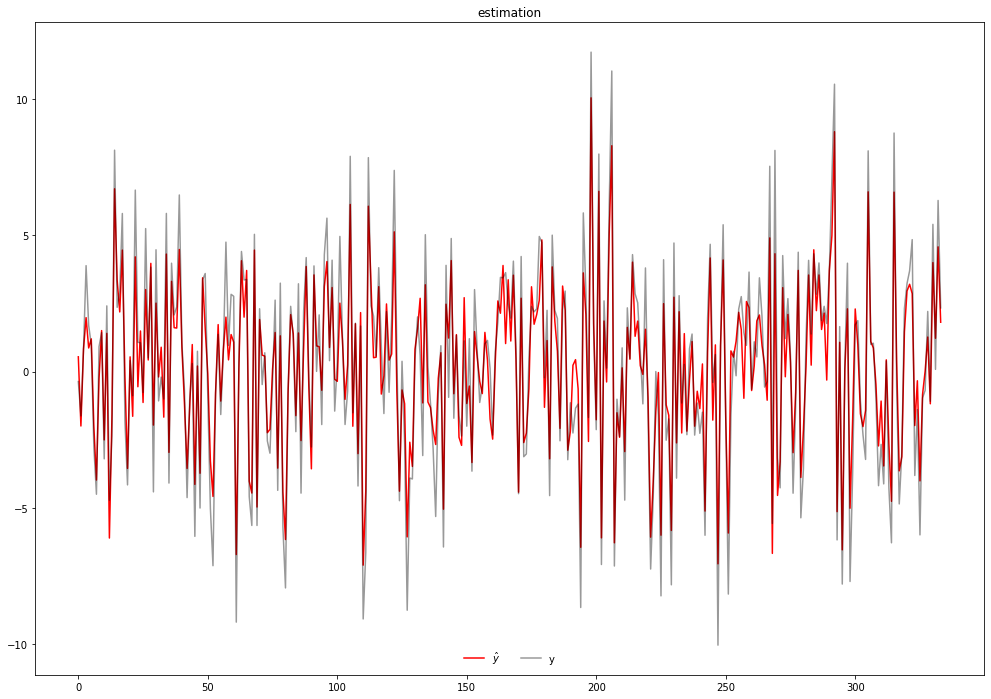

MSE on Y_test : 1.54


In [41]:
Est_EN=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=True,plot_estim=True,MISE=True)

### $\bullet $ Lasso

 best parameter : ({'alpha': 0.1104091144541991},)
 MSE on train set= [1.33] 




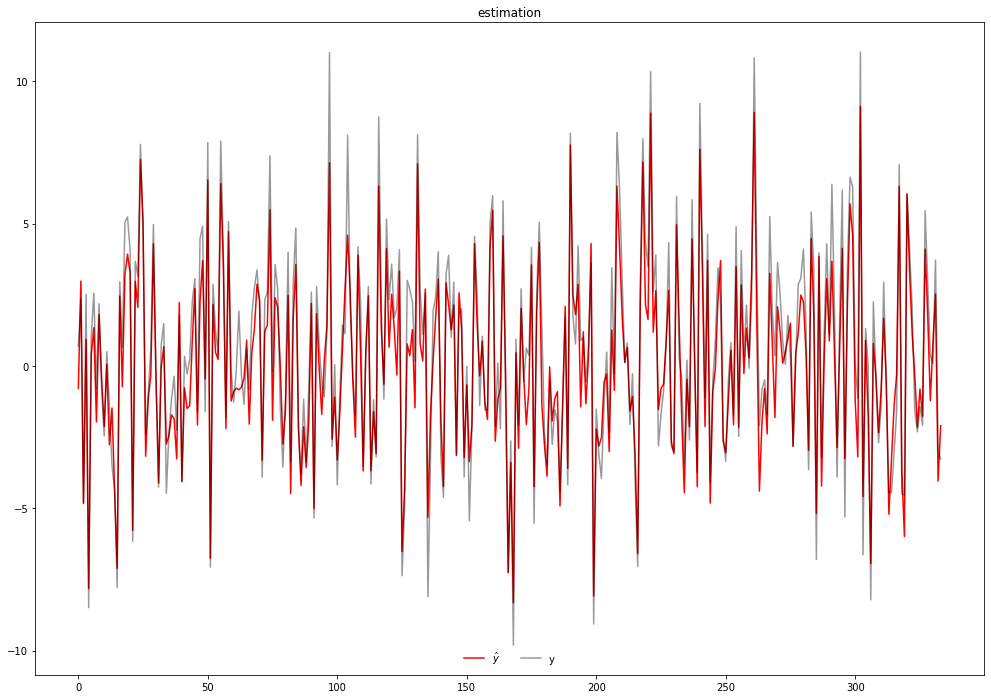

MSE on Y_test : 1.32


In [42]:
Est_L=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=True,plot_estim=True,MISE=True)

### $\bullet$ Ridge

 Le meilleur param?tre est : ({'alpha': 0.98930219138472},)
 MSE sur les données entrainement = [14.69] 




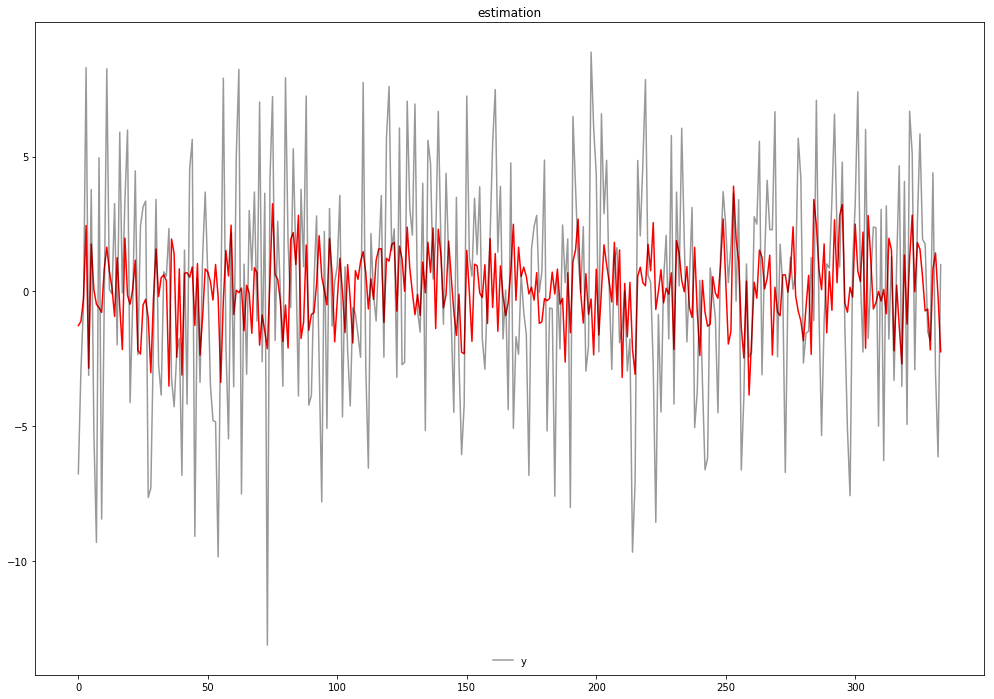

MSE avec le Y_test : 14.93


In [96]:
Est_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=True,plot_estim=True,MISE=True) 

## Best predictor 

In [66]:
print(' Prediction using Lasso')
Pred_L=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=False,plot_estim=False,MISE=True)
print('----------------------------\n Prediction using Ridge')
Pred_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=False,plot_estim=False,MISE=True) 

print('----------------------------\n Prediction using ElasticNet')
Pred_EN=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X1,Y=Y1,fit=True,best=False,plot_estim=False,MISE=True)

 Prediction using Lasso
MSE on Y_test : 1.07
----------------------------
 Prediction using Ridge
MSE on Y_test : 14.88
----------------------------
 Prediction using ElasticNet
MSE on Y_test : 1.84


The  Estimation using $\textbf{Lasso}$ achieves the best prediction among the three predictor

## 2) Find the best estimator but this time replacing $\beta$ by $\beta_1=\dots=\beta_{1500}=1$ 

In [61]:
#Sparse parameter 
s2 = 1500
p = 5000
n = 1000
beta = np.array([1 for i in range(s)] + [0 for i in range(p-s)])
eta = np.random.randn(n)
X2 = np.random.randn(n,p)
Y2 = np.matmul(X1, beta) + eta

## Estimation using the three regression model

### $\bullet$ ElasticNet

 best parameter : ({'l1_ratio': 0.4081632653061224, 'alpha': 0.8333333333333333},)
 MSE on train set= [15.17] 




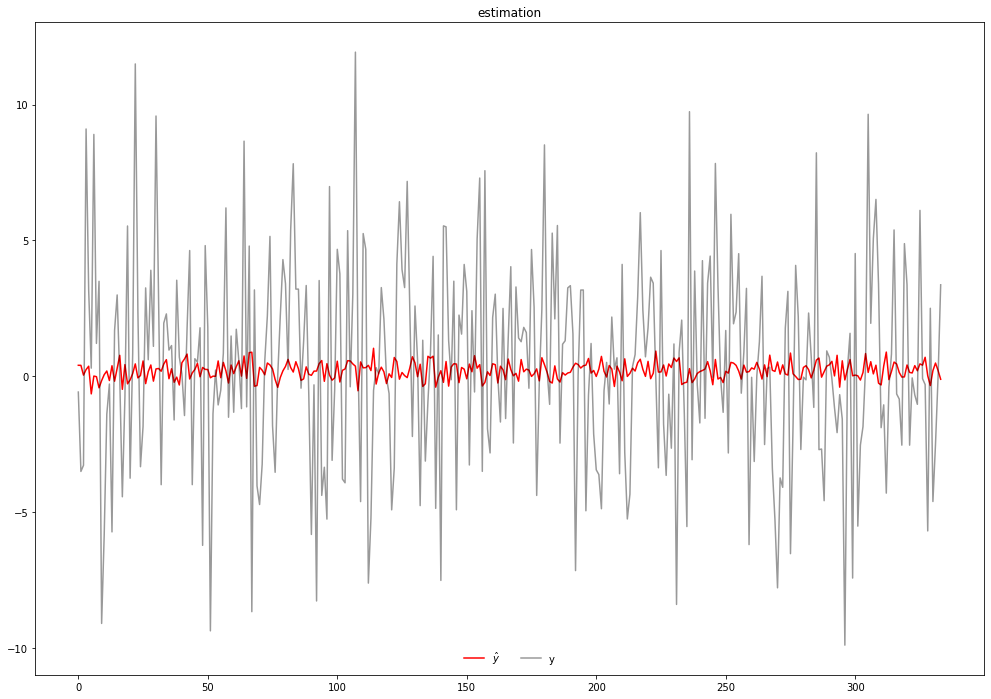

MSE on Y_test : 14.48


In [62]:
Est_EN=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True)

### $\bullet$ Lasso

 best parameter : ({'alpha': 0.41666666666666663},)
 MSE on train set= [15.47] 




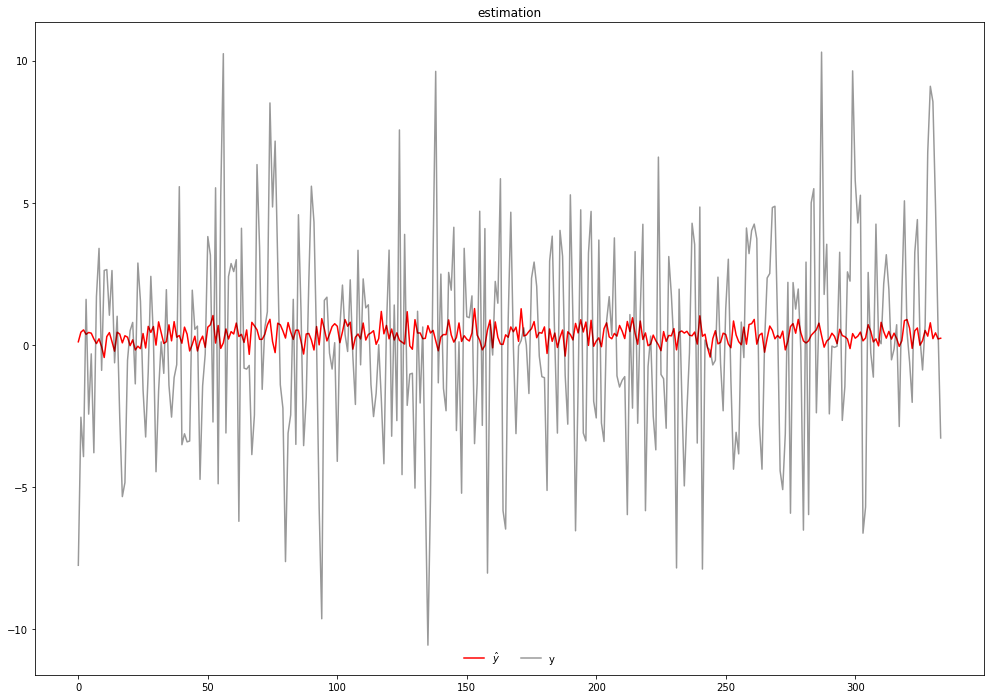

MSE on Y_test : 12.53


In [90]:
Est_L=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=10,n_iter=75,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True)

### $\bullet$ Ridge

 best parameter : ({'alpha': 1.0},)
 MSE on train set= [14.05] 




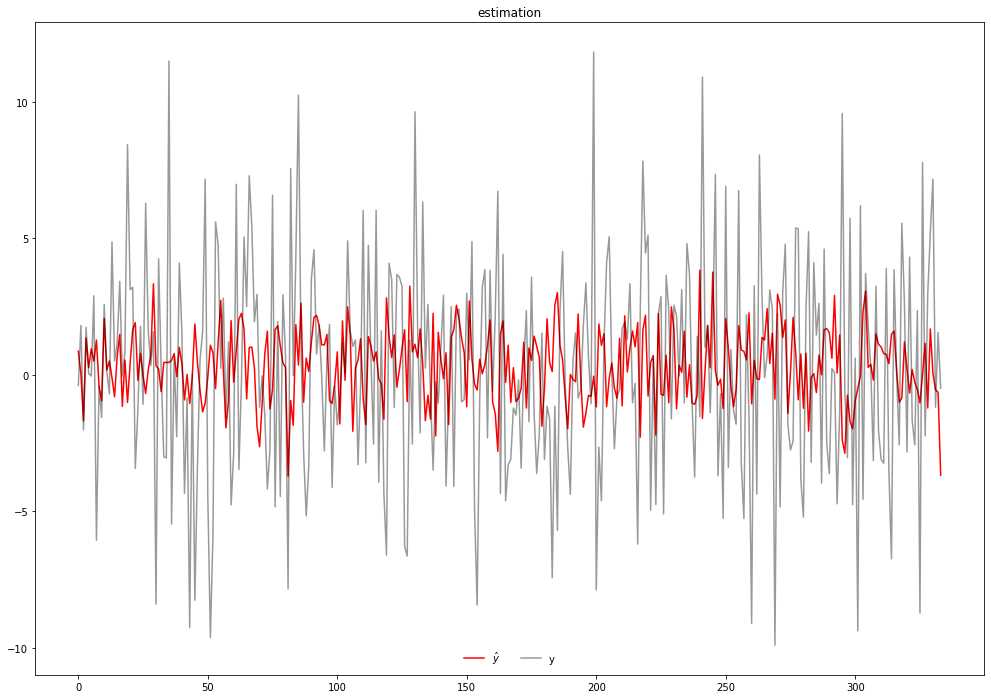

MSE on Y_test : 17.3


In [70]:
Est_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True)

## Selecting the best Predictor

In [75]:
print(' Prediction using Lasso')
f_R=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X2,Y=Y2,fit=True,best=False,plot_estim=False,MISE=True) 
print('----------------------------\n Prediction using Ridge')
f_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X2,Y=Y2,fit=True,best=False,plot_estim=False,MISE=True) 

print('----------------------------\n Prediction using ElasticNet')
f_R=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=X2,Y=Y2,fit=True,best=False,plot_estim=False,MISE=True) 

 Prediction using Lasso
MSE on Y_test : 14.95
----------------------------
 Prediction using Ridge
MSE on Y_test : 16.71
----------------------------
 Prediction using ElasticNet
MSE on Y_test : 15.45


The best predictor among the three for this setting is $\textbf{Lasso}$

##  3) Same question with n=100, p=50 and $\beta_1=\beta_2=10, \beta_3=\beta_4=5, \beta_5=\dots=\beta_{14}=1$  

In [79]:
s3 = [10,10,5,5] + [1 for i in range(10)]
p3 = 50
n3 = 100

COV_MAT = np.ones((p3,p3))
for i in range(p3) :
    for j in range(p3) : 
        if(i!=j):
            COV_MAT[i][j] = 0.7**(np.abs((i+1)-(j+1)))

beta2 = np.array([i for i in s3] + [0 for i in range(p3-len(s3))])
eta2 = np.random.randn(n3)
Xc  = np.random.multivariate_normal(np.zeros(p3), COV_MAT, size = n3)
yc = np.matmul(Xc, beta2) + eta2

print(np.shape(Xc))

(100, 50)


## modeling the three cases

### $\bullet$ Lasso

 Le meilleur parametre est : ({'alpha': 0.08333333333333333},)
 MSE sur les données entrainement = [1.85] 




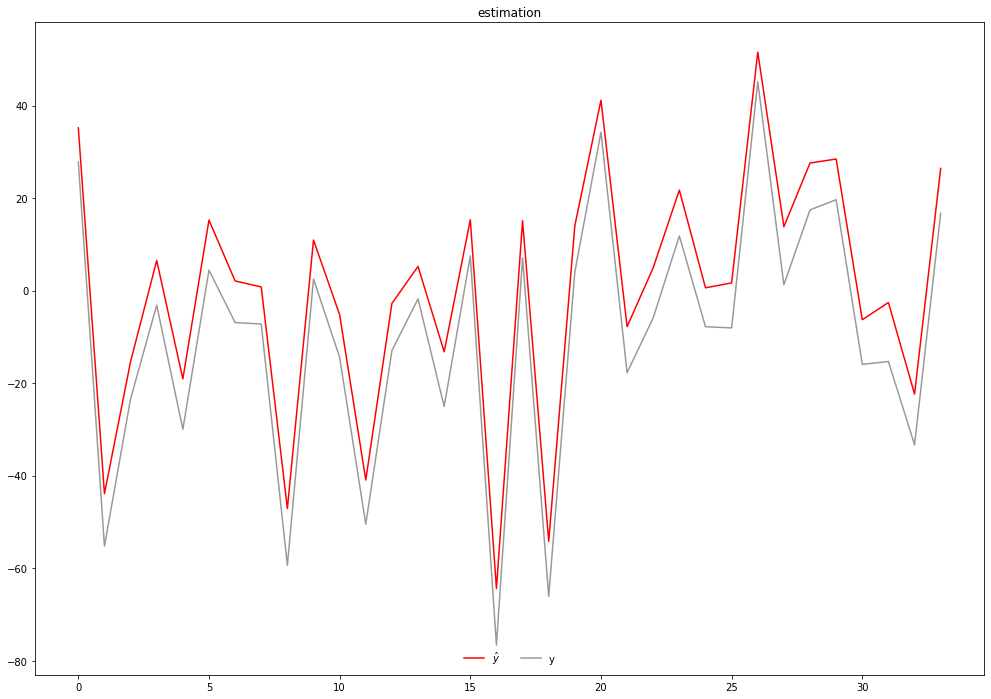

MSE avec le Y_test : 97.18


In [81]:
Pred_L=tout(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=5,n_iter=5,X=Xc,Y=yc,fit=True,best=True,plot_estim=True,MISE=True) 

### $\bullet$ Ridge

 best parameter : ({'alpha': 0.16666666666666666},)
 MSE on train set= [4.78] 




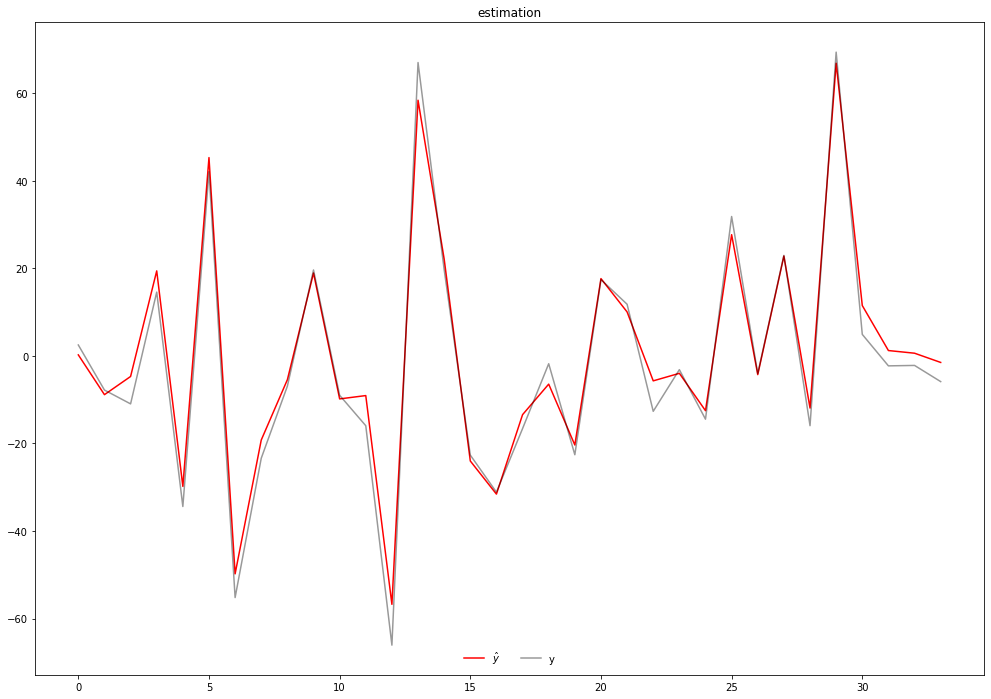

MSE on Y_test : 17.14


In [82]:
pred_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=Xc,Y=yc,fit=True,best=True,plot_estim=True,MISE=True) 

### $\bullet$ ElasticNet

 best parameter : ({'l1_ratio': 0.44897959183673464, 'alpha': 0.08333333333333333},)
 MSE on train set= [3.31] 




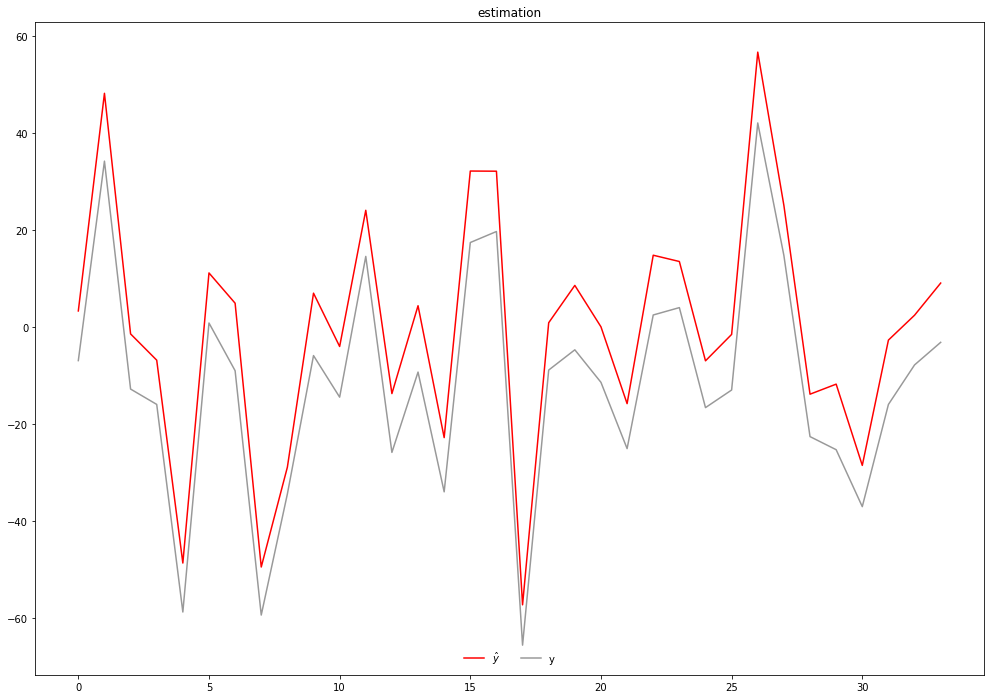

MSE on Y_test : 127.89


In [83]:
Pred_E=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=Xc,Y=yc,fit=True,best=True,plot_estim=True,MISE=True) 

## Selecting best predictor

In [84]:
print(' Prediction using Lasso')
f_R=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=Xc,Y=yc,fit=True,best=False,plot_estim=False,MISE=True) 
print('----------------------------\n Prediction using Ridge')
f_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=Xc,Y=yc,fit=True,best=False,plot_estim=False,MISE=True) 

print('----------------------------\n Prediction using ElasticNet')
f_R=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=5,n_iter=30,X=Xc,Y=yc,fit=True,best=False,plot_estim=False,MISE=True) 

 Prediction using Lasso
MSE on Y_test : 1.15
----------------------------
 Prediction using Ridge
MSE on Y_test : 2.82
----------------------------
 Prediction using ElasticNet
MSE on Y_test : 4.19


## Real Data World Case Study using UCI-Machine Learning Datasets
### Air Quality Dataset 
https://archive.ics.uci.edu/ml/datasets/Air+Quality

In [122]:
import zipfile
link_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
LocalFile= 'AirQualityUCI.zip'
urllib.request.urlretrieve(link_data, LocalFile)
#First open the local zip file as a zipFile object
zf = zipfile.ZipFile(LocalFile)
#Name the folder we'll create the same as the file, without the extension
outFolderName = LocalFile[:-4]

#use the os module to do check if the folder exists, and create if not
import os
if not os.path.exists(outFolderName): 
    outFolderName = os.mkdir(LocalFile[:-4])
#Files Content
zf.namelist()
df = pd.read_csv(zf.open('AirQualityUCI.csv'), skiprows=2, index_col=False)

### Importing our Dataset

In [143]:
os.getcwd()
os.chdir('C:\\Users\\USER INFO\Desktop')
df=pd.read_csv("AirQualityUCI.csv")

## Data Description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

In [148]:
df.head(5)

,Date,Time,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,Nox_GT,PT08_S3_Nox,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH,CO_level
0,11/23/2004,19:00:00,11.9,2008,-200,50.6,1980,1389,325,220,2562,2342,12.4,74.7,1.0741,Very High
1,11/23/2004,20:00:00,11.5,1918,-200,49.4,1958,1358,335,190,2477,2237,11.5,76.2,1.0324,Very High
2,11/17/2004,18:00:00,10.2,1802,-200,47.7,1924,748,356,192,2235,2452,13.7,52.8,0.8244,Very High
3,11/23/2004,18:00:00,10.2,1982,-200,49.5,1959,1369,322,227,2536,2386,13.2,72.6,1.0936,Very High
4,11/26/2004,18:00:00,10.1,1956,-200,45.2,1877,1389,347,255,2338,2465,15.5,62.8,1.0979,Very High


In [152]:
df.describe()

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,Nox_GT,PT08_S3_Nox,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH', 'CO_level'],
      dtype='object')


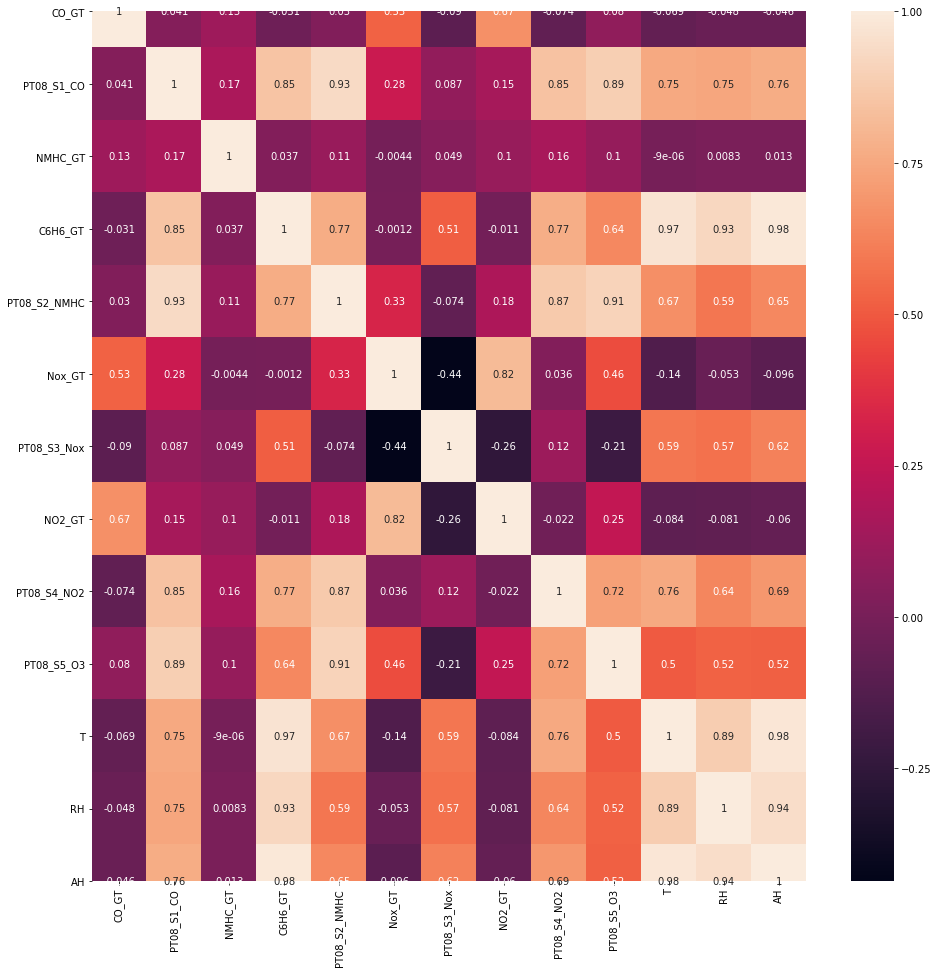

In [296]:
print(df.columns)
df.shape
plt.figure(figsize=(16,16))
sns.heatmap(df[list(df.dtypes[df.dtypes!='object'].index)].corr(),annot=True)
plt.show()

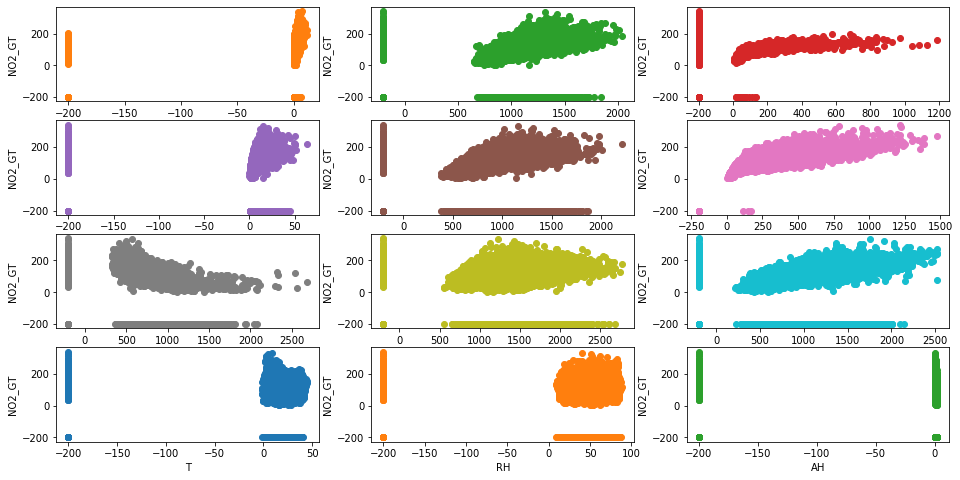

In [297]:
plt.figure(figsize=(16,8))

list_columns = ['CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH']

colors = [x['color'] for x in plt.rcParams["axes.prop_cycle"]]*3

 

for count , col  in enumerate(list_columns, start = 1):
    

    plt.subplot(4,3,count)

    plt.scatter(df[col], df['NO2_GT'], c = colors[count])
    plt.xlabel(col)
    plt.ylabel('NO2_GT')


From the graph above the best variable to use for our linear regression are : 

'PT08_S5_O3', 'PT08_S3_Nox','PT08_S2_NMHC','PT08_S4_NO2','Nox_GT','PT08_S1_CO','NMHC_GT'



## Pre-processing phase

In [318]:
X = df.select_dtypes("number")
X.drop(columns = ["CO_GT",'C6H6_GT','NO2_GT'], inplace = True)

# #Changing our categorical variables to Numerical variables 
X = pd.concat([X, pd.get_dummies(df['CO_level'])], axis = 1)
# X2= pd.concat([X, pd.get_dummies(df['CO_level'])], axis = 1)

#Vector to Predict
y = df[["NO2_GT"]]
# y2 = df[["CO_GT"]]

#Split our Data
# X_train, X_test, y_train, y_test = train_test_split(X2,y2, train_size = 2/3)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 2/3)
np.shape(X)

(9357, 15)

### $\bullet$ Prediction using Lasso()

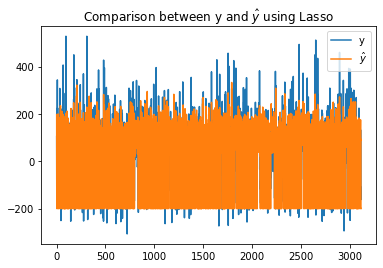

In [340]:
las=Lasso()
las.fit(X_train, y_train)
pred=las.predict(X_test)
y_testl=y_test.values.tolist()
plt.plot(pred)
plt.plot(y_testl)
plt.legend(["y",r'$\hat{y}$'])
plt.title(r'Comparison between y and $\hat{y}$ using Lasso')
plt.show()

### $\bullet$ Prediction using Ridge()

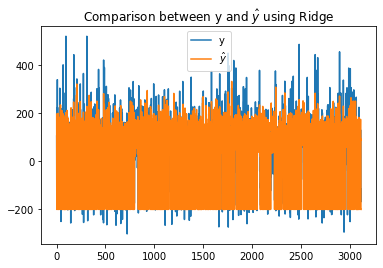

In [339]:
rid=Ridge()
rid.fit(X_train, y_train)
pred=rid.predict(X_test)
y_testl=y_test.values.tolist()
plt.plot(pred)
plt.plot(y_testl)
plt.title(r'Comparison between y and $\hat{y}$ using Ridge')
plt.legend(["y",r'$\hat{y}$'])
plt.show()

### $\bullet$ Prediction using ElasticNet()

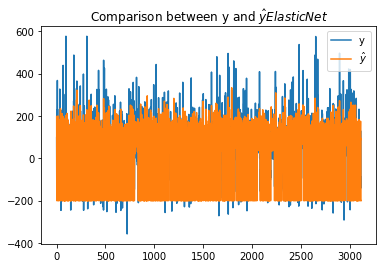

In [338]:
EN=ElasticNet()
EN.fit(X_train, y_train)
pred=EN.predict(X_test)
y_testl=y_test.values.tolist()
plt.plot(pred)
plt.plot(y_testl)
plt.legend(["y",r'$\hat{y}$'])
plt.title(r'Comparison between y and $\hat{y}  ElasticNet$')
plt.show()

## Prediction and comparison admist the previous regression models

### $\bullet$ Ridge

 best parameter : ({'alpha': 1.0},)
 MSE on train set= [16.44] 




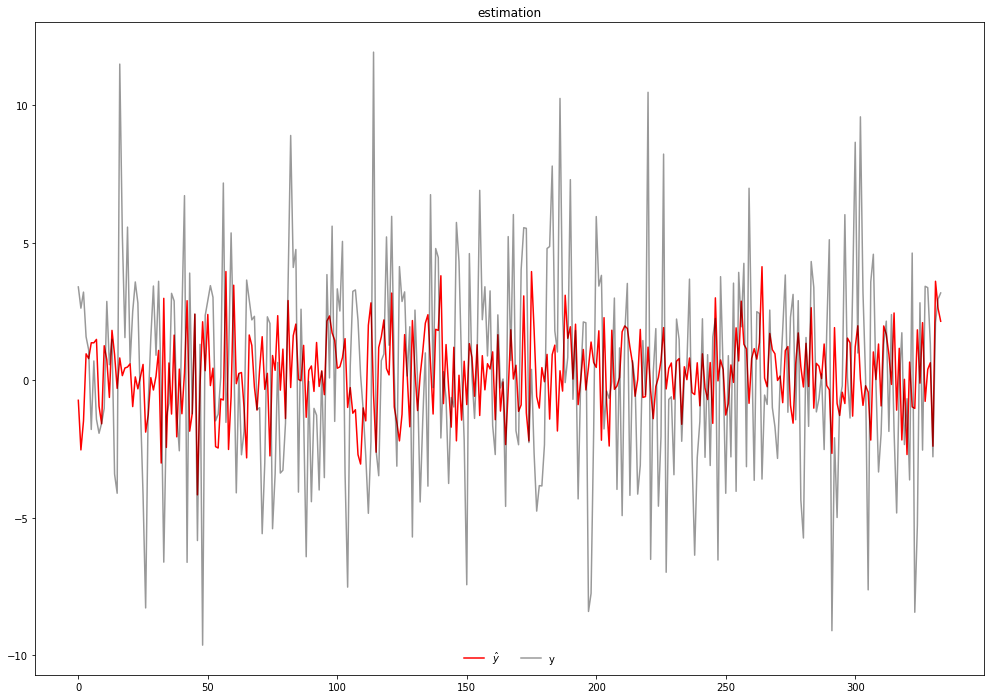

MSE on Y_test : 15.21


In [295]:
Est_R=Regest(E=Ridge(),param=parametre_ridre,score="neg_mean_squared_error"
     ,cv=10,n_iter=30,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True) 

### $\bullet$ Lasso

 best parameter : ({'alpha': 0.375},)
 MSE on train set= [13.6] 




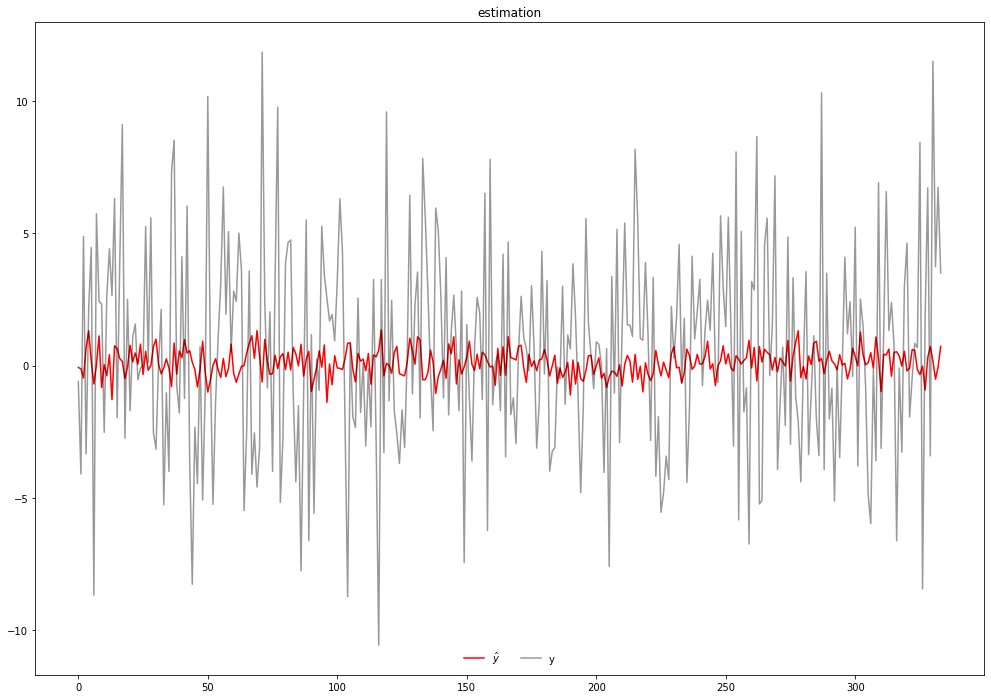

MSE on Y_test : 15.86


In [260]:
Est_L=Regest(E=Lasso(),param=parametres_lasso,score="neg_mean_squared_error",
             cv=5,n_iter=10,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True)

### $\bullet$ ElasticNet

 best parameter : ({'l1_ratio': 0.4081632653061224, 'alpha': 1.0},)
 MSE on train set= [14.17] 




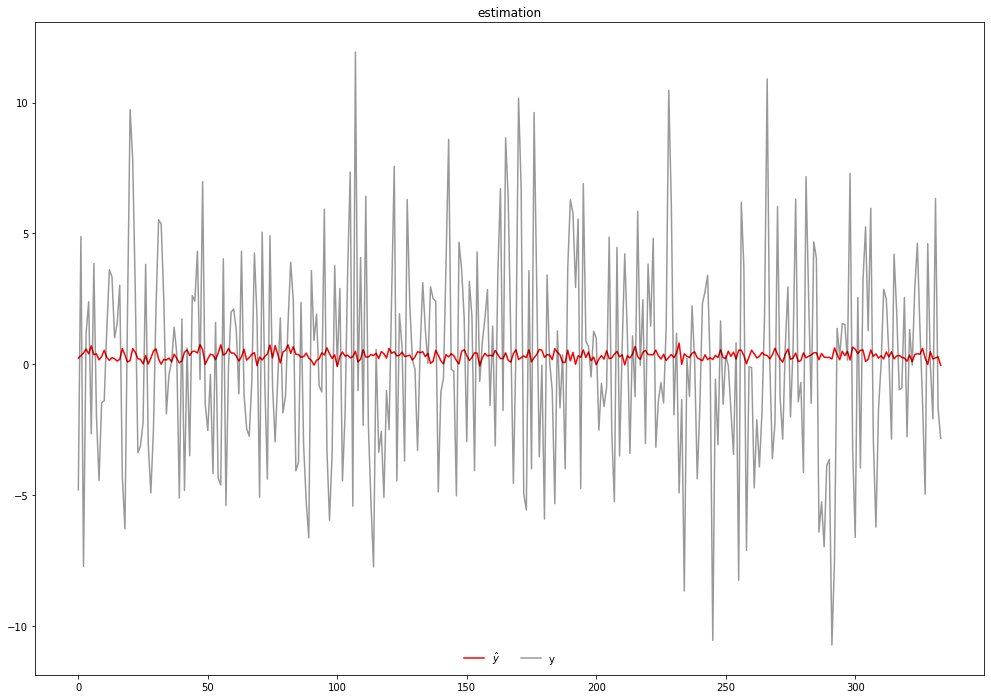

MSE on Y_test : 15.37


In [211]:
Est_EN=Regest(E=ElasticNet(),param=parameters_elastic,score="neg_mean_squared_error"
     ,cv=10,n_iter=30,X=X2,Y=Y2,fit=True,best=True,plot_estim=True,MISE=True)